In [1]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cuda")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cpu")

CUDA is available!  Training on GPU ...


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
import os
from skimage.io import imread
root = 'segmentation'

for root, dirs, files in os.walk(os.path.join(root)):
    for file in files:
        if file.endswith('s.png'):
            lesions.append(imread(os.path.join(root, files[0])))
        else:
            images.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [13]:
from skimage.transform import resize
size = (512, 512)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.05 for y in lesions]

In [14]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 25 images


In [15]:
len(lesions)

25

In [16]:
len(X)

25

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

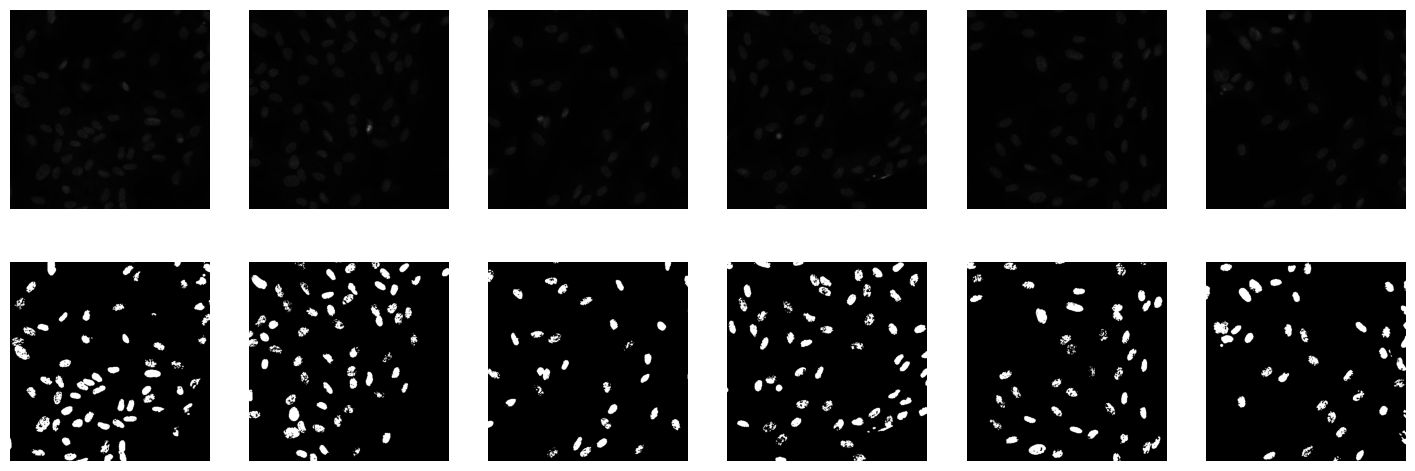

In [17]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [18]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [12, 20])

In [19]:
print(len(tr), len(val), len(ts))

12 8 5


#### PyTorch DataLoader

In [20]:
from torch.utils.data import DataLoader
batch_size = 2
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

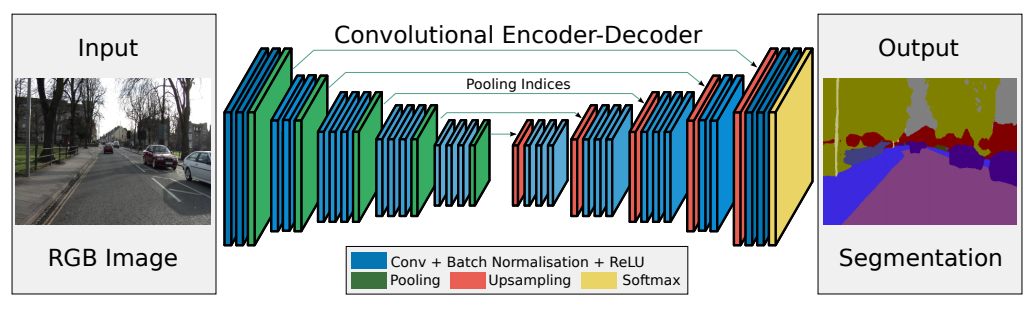

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [22]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU()
                        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
                          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU()
                        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
                          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU()
                        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
                          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU()
                        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, stride=1),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0, stride=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU()
                              )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                          nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU()
                        )
        
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                          nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU()
                        )
        
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU()
                        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                          nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(1),
                          nn.ReLU(),

                          nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=1),
                          nn.BatchNorm2d(1),
                        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,  ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [23]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels  = labels.squeeze(1).byte()   # Forming outputs to the correct form
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [24]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real*y_pred + (1+ torch.exp(-1*y_pred)).log()
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [25]:
def train(model, optimizer, scheduler, loss_fn, score_fn, epochs, data_tr, data_vl, device):

    torch.cuda.empty_cache()

    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)            

            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            print("Y_pred len: ", Y_pred.size())
            print("Y_batch len: ", Y_batch.size())
            loss = loss_fn(Y_pred, Y_batch) # forward-pass

            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('train_loss: %f' % avg_loss)
        losses_train.append(avg_loss)

        # train score
        avg_score_train = score_fn(model, iou_pytorch, data_tr)
        scores_train.append(avg_score_train)

        # val loss
        avg_loss_val = 0
        model.eval()  # testing mode
        for X_val, Y_val in data_vl:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu

                loss = loss_fn(Y_hat, Y_val) # forward-pass
                avg_loss_val += loss / len(data_vl)

        toc = time()
        print('val_loss: %f' % avg_loss_val)
        losses_val.append(avg_loss_val)

        # val score
        avg_score_val = score_fn(model, iou_pytorch, data_vl)
        scores_val.append(avg_score_val)

        if scheduler:
            #scheduler.step(avg_score_val)
            scheduler.step()

        torch.cuda.empty_cache()
          
    return (losses_train, losses_val, scores_train, scores_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [26]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch.to(DEVICE) for X_batch, _ in data]
    return np.array(Y_pred)

In [27]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
            X_batch.to(DEVICE)
            Y_label.to(DEVICE)
            Y_pred = model(X_batch)
            
            #We need to make outputs in the range from 0 to 1, as masks are
            #If output is bigger than treshhold level => it is 1, else - zero            
            #Treshold is 0.1
            
            # 'torch.ones_like' returns the tensor with the size like the input matrix size
            Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.1)
            scores += metric(Y_pred, Y_label.to(DEVICE)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [28]:
model = SegNet().to(DEVICE)

In [29]:
max_epochs = 20

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma=0.7)
results = train(model, optimizer, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val, DEVICE)


* Epoch 1/20
Y_pred len:  torch.Size([2, 1, 512, 512])
Y_batch len:  torch.Size([2, 1, 512, 512, 3])


RuntimeError: The size of tensor a (512) must match the size of tensor b (3) at non-singleton dimension 4

In [19]:
score_model(model, iou_pytorch, data_val)

0.7060000002384186

Ответьте себе на вопрос: не переобучается ли моя модель?


In [18]:
# Function to build training plots 
def plot_results(rslts, ttl=''):
    # This part is needed to proceed the error with torch.no_grad
    with torch.no_grad():
        plt.figure(figsize=(15, 9))
        plt.plot(rslts[0], label="train_loss")
        plt.plot(rslts[1], label="val_loss")
        plt.plot(rslts[2], label="train_score")
        plt.plot(rslts[3], label="val_score")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(ttl)
        plt.show()

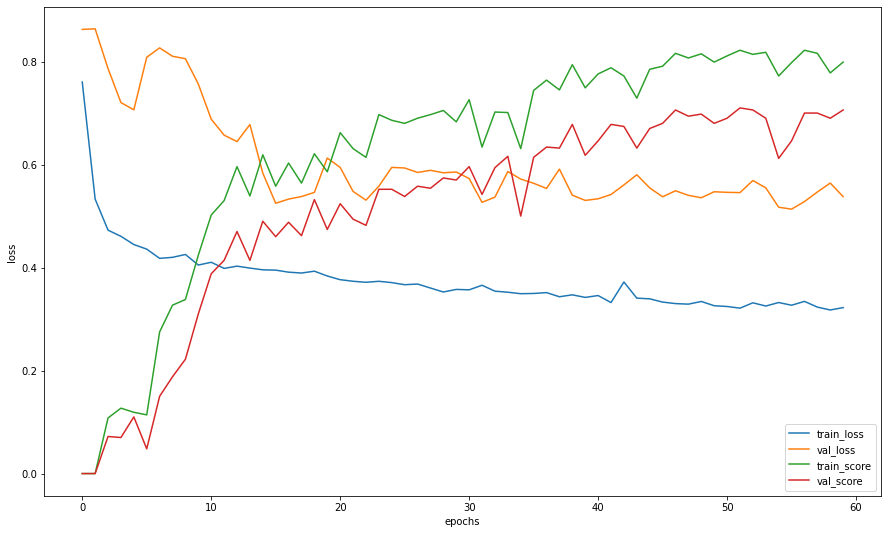

In [21]:
plot_results(results)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [42]:
def dice_loss(y_real, y_pred):
    
    smooth = 1e-8
    outputs = y_pred.sigmoid().squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = y_real.squeeze(1)    

    num = (outputs * labels).sum()
    den = (outputs + labels).sum()
    res = 1 - ((2. * num + smooth) / (den + smooth))#/(256*256)
    
    return res 

Проводим тестирование:

In [43]:
model_dice = SegNet().to(DEVICE)

max_epochs = 60
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.7)
results_dice = train(model_dice, optimizer, scheduler, dice_loss, score_model, max_epochs, data_tr, data_val, DEVICE)

* Epoch 1/60


RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 3

In [44]:
score_model(model_dice, dice_loss, data_val)

RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 3

In [ ]:
plot_results(results_dice)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [45]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y = y_pred.sigmoid()+eps
    loss = -((1-y)**gamma*y_real*y.log()+(1-y_real)*(1-y).log())
    return loss.mean()


In [46]:
model_focal = SegNet().to(DEVICE)

max_epochs = 60
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.7)
results_focal = train(model_focal, optimizer, scheduler, focal_loss, score_model, max_epochs, data_tr, data_val, DEVICE)

* Epoch 1/60


RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 4

In [45]:
score_model(model_focal, focal_loss, data_val)

0.5555656254291534

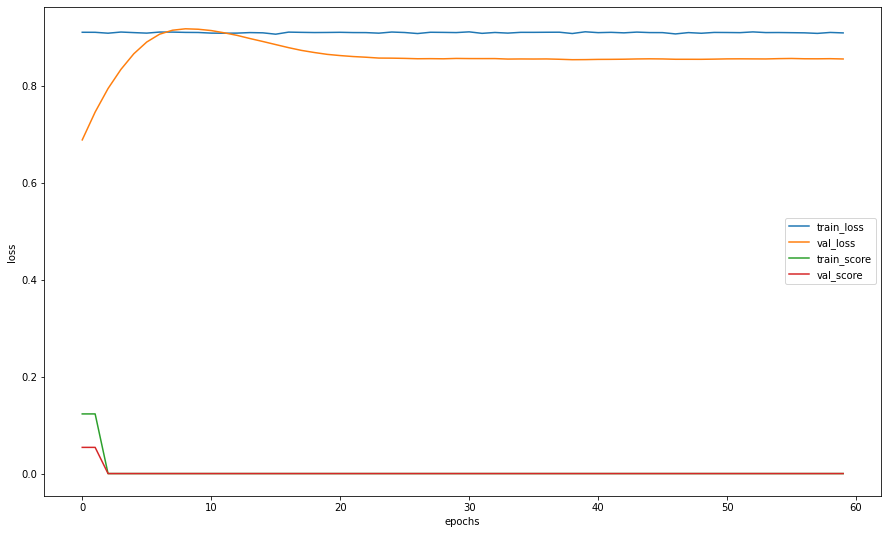

In [46]:
plot_results(results_focal)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

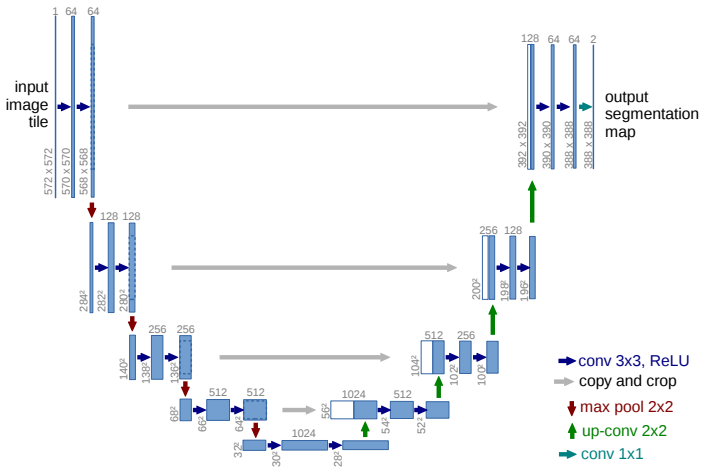

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [47]:
# Вспомогательный класс. Реализация синего слоя с картинки выше

class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2DBatchNormRelu, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [48]:
unet_model = UNet().to(DEVICE)

In [49]:
max_epochs = 20
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20, 40], gamma=0.7)
results_unet = train(unet_model, optimizer, scheduler, focal_loss, score_model, max_epochs, data_tr, data_val, DEVICE)

* Epoch 1/20


RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 4

In [50]:
score_model(unet_model, bce_loss, data_val)

0.6222447454929352

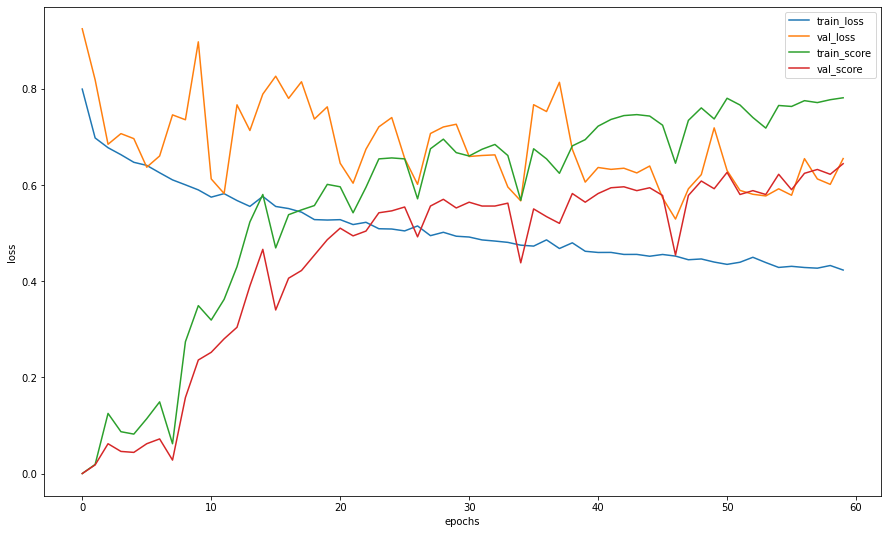

In [53]:
plot_results(results_unet)

In [25]:
def plot_items(model, loader, cnt):

    model.eval()
    X, Y = next(iter(loader))
    X = X.to(DEVICE)
    Y = Y.to(DEVICE)
    Y_pred = model(X)

    p = Y_pred.detach().cpu()
    p_post = torch.ones_like(p) * (p > 0.1)
    y = Y.detach().cpu()
    
    plt.figure(figsize=(15, 10))
    for i in range(cnt):
        plt.subplot(3, cnt, i+1+cnt*0)
        plt.imshow(np.rollaxis(p[i,0].numpy(), 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        
        plt.subplot(3, cnt, i+1+cnt*1)
        plt.imshow(np.rollaxis(p_post[i,0].numpy(), 0), cmap='gray')
        plt.title('Post-processing')
        plt.axis('off')

        plt.subplot(3, cnt, i+1+cnt*2)
        plt.imshow(np.rollaxis(y[i,0].numpy(), 0), cmap='gray')
        plt.title('Real')
        plt.axis('off')

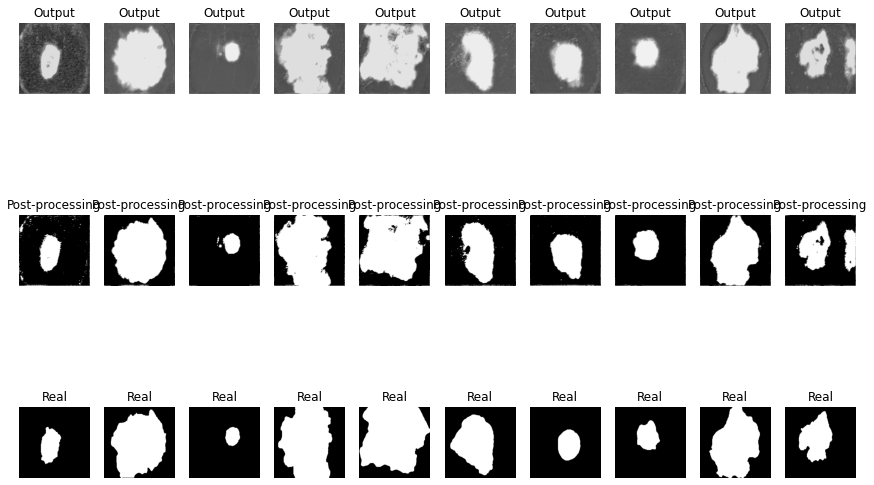

In [52]:
plot_items(unet_model, data_ts, 10)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [26]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(64),
             nn.ReLU(),

             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(64),
             nn.ReLU(),
            
             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(64),
             nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)

        self.enc_conv1 = nn.Sequential(
             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(128),
             nn.ReLU(),

             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(128),
             nn.ReLU(),
            
             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(128),
             nn.ReLU()      
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(256),
             nn.ReLU(),

             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(256),
             nn.ReLU(),
            
             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(256),
             nn.ReLU()           
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),

             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(512),
             nn.ReLU(),
            
             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(512),
             nn.ReLU()  
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(1024),
             nn.ReLU(),

             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1),
             nn.BatchNorm2d(512),
             nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512*2, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256*2, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128*2, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64*2, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, output_size=pre_e0.size()), pre_e0], 1))
        # no activation
        return d0


In [27]:
unet2_model = UNet2().to(DEVICE)


In [29]:
max_epochs = 60
optimizer = torch.optim.AdamW(unet2_model.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.7)
results_unet = train(unet2_model, optimizer, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val, DEVICE)

* Epoch 1/60
train_loss: 0.694408
val_loss: 0.790797
* Epoch 2/60
train_loss: 0.581079
val_loss: 0.796175
* Epoch 3/60
train_loss: 0.570270
val_loss: 0.794046
* Epoch 4/60
train_loss: 0.546536
val_loss: 0.682864
* Epoch 5/60
train_loss: 0.541858
val_loss: 0.636081
* Epoch 6/60
train_loss: 0.517846
val_loss: 0.785990
* Epoch 7/60
train_loss: 0.507768
val_loss: 0.544143
* Epoch 8/60
train_loss: 0.487784
val_loss: 0.503552
* Epoch 9/60
train_loss: 0.483025
val_loss: 0.472354
* Epoch 10/60
train_loss: 0.467165
val_loss: 0.588852
* Epoch 11/60
train_loss: 0.467802
val_loss: 0.476896
* Epoch 12/60
train_loss: 0.455709
val_loss: 0.501371
* Epoch 13/60
train_loss: 0.454659
val_loss: 0.598754
* Epoch 14/60
train_loss: 0.452844
val_loss: 0.582997
* Epoch 15/60
train_loss: 0.449089
val_loss: 0.497975
* Epoch 16/60
train_loss: 0.439921
val_loss: 0.474106
* Epoch 17/60
train_loss: 0.441524
val_loss: 0.509829
* Epoch 18/60
train_loss: 0.438855
val_loss: 0.473038
* Epoch 19/60
train_loss: 0.437511
va

In [30]:
score_model(unet2_model, bce_loss, data_val)

0.5939583480358124

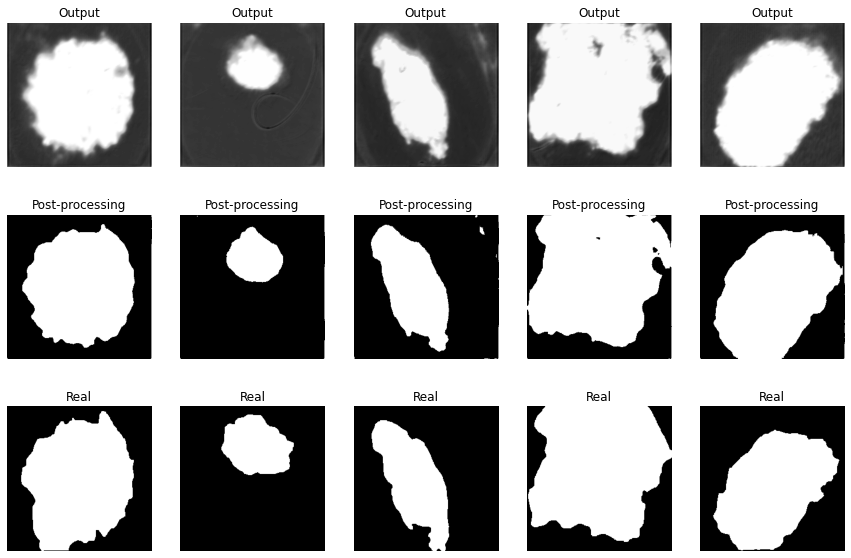

In [31]:
plot_items(unet2_model, data_ts, 5)

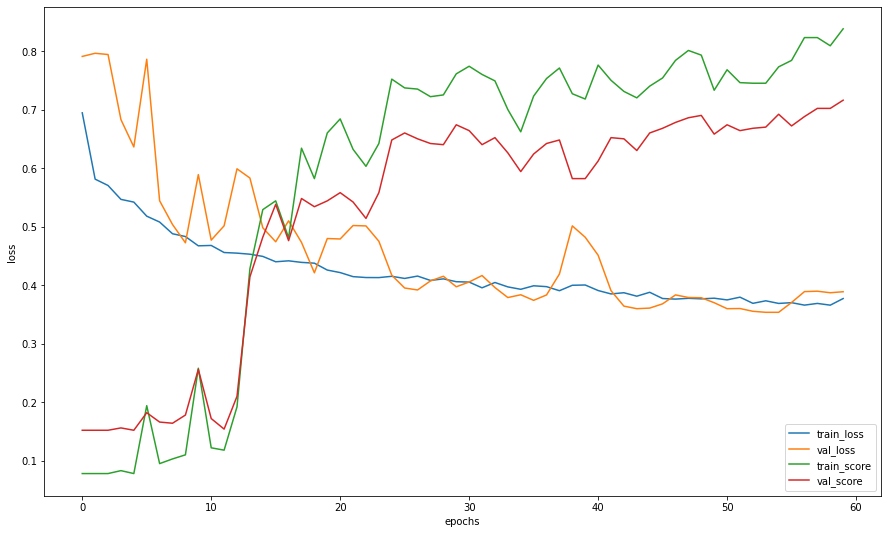

In [32]:
plot_results(results_unet)

In [33]:
max_epochs = 80
optimizer = torch.optim.AdamW(unet2_model.parameters(), lr=0.00100, weight_decay=0.07)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,25,30,40,60,65,70], gamma=0.8)
results_unet_new = train(unet2_model, optimizer, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val, DEVICE)

* Epoch 1/80
train_loss: 0.467927
val_loss: 0.390560
* Epoch 2/80
train_loss: 0.414535
val_loss: 0.315233
* Epoch 3/80
train_loss: 0.410738
val_loss: 0.291269
* Epoch 4/80
train_loss: 0.398615
val_loss: 0.346559
* Epoch 5/80
train_loss: 0.387887
val_loss: 0.344359
* Epoch 6/80
train_loss: 0.392681
val_loss: 0.313483
* Epoch 7/80
train_loss: 0.375134
val_loss: 0.298985
* Epoch 8/80
train_loss: 0.369259
val_loss: 0.412861
* Epoch 9/80
train_loss: 0.360548
val_loss: 0.390656
* Epoch 10/80
train_loss: 0.354871
val_loss: 0.569914
* Epoch 11/80
train_loss: 0.353173
val_loss: 0.529264
* Epoch 12/80
train_loss: 0.356741
val_loss: 0.375174
* Epoch 13/80
train_loss: 0.347383
val_loss: 0.334240
* Epoch 14/80
train_loss: 0.349222
val_loss: 0.334664
* Epoch 15/80
train_loss: 0.340741
val_loss: 0.438138
* Epoch 16/80
train_loss: 0.333820
val_loss: 0.322014
* Epoch 17/80
train_loss: 0.335788
val_loss: 0.276930
* Epoch 18/80
train_loss: 0.333317
val_loss: 0.324117
* Epoch 19/80
train_loss: 0.337544
va

In [34]:
score_model(unet2_model, bce_loss, data_val)

0.5843962728977203

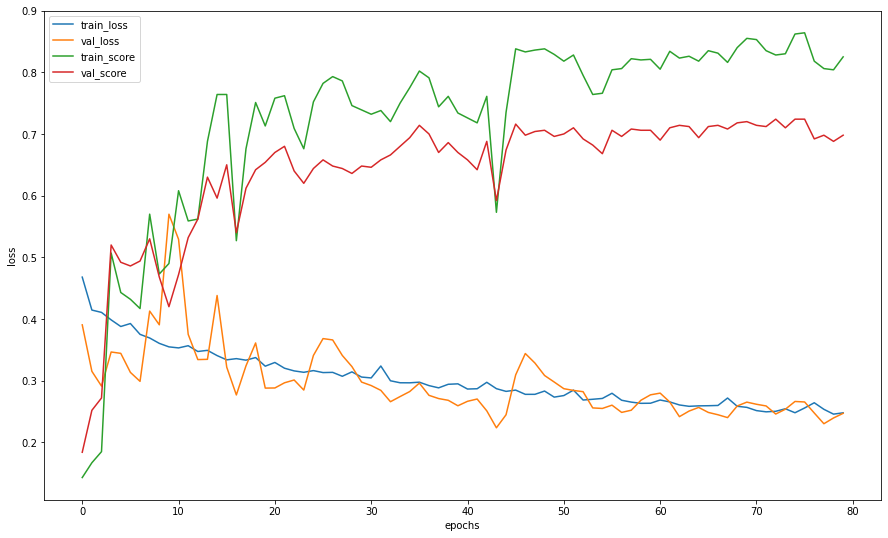

In [35]:
plot_results(results_unet_new)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.